# 3. MLOps and Operationalisation

## 3.1 Overview of the MLOps stack

This notebook constitutes the third part of the project, following the exploratory analysis performed in the [first notebook](1_EDA.ipynb) and the modeling study developed in the [second notebook](2_models.ipynb). After examining the dataset’s characteristics and evaluating a range of deep learning architectures, we now focus on the operational dimension of the workflow.

The objective of this notebook is to document the MLOps components that support the training, tracking, reproducibility, and deployment of the image classification system built for the Food-101 dataset. These elements form the infrastructure that enables systematic experimentation, consistent execution across environments, reliable versioning, and accessible model demonstration.

We begin by examining how experiment tracking is handled through MLflow, including the logging of metrics, artifacts, and model signatures during training. We then describe the role of containerisation using Docker to ensure reproducible environments and controlled execution. The continuous integration and delivery pipeline is presented next, highlighting how automated testing and image publication maintain code quality and operational consistency. Finally, we detail the Streamlit-based demo that provides an interactive interface for running inference on new images using the trained model.

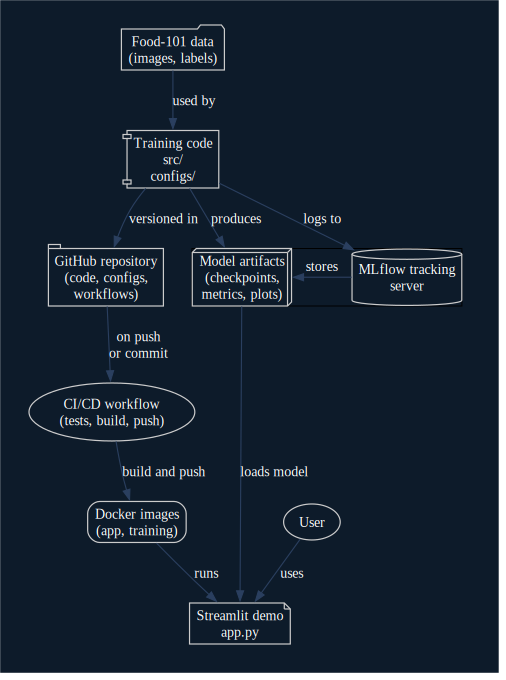

In [5]:
import os
os.chdir(os.path.dirname(os.getcwd()))
from src.notebook.mlops_utils import build_mlops_overview_graph
build_mlops_overview_graph()

The diagram provides a high-level view of the operational workflow supporting the Food-101 image classification project. It complements the modelling work presented in the earlier notebooks by illustrating how the different components interact during development, training, experiment tracking, and deployment.

At the top of the workflow, the training code consumes the Food-101 dataset to produce model artifacts such as checkpoints, metrics, and diagnostic plots. These artifacts form the core outputs of each experiment. In parallel, the same training process logs metadata, parameters, and evaluation results to the MLflow tracking server, which serves as a structured record of all experiments. MLflow therefore maintains both the descriptive metadata of each run and, through its coupling with the filesystem, the storage of the generated artifacts.

The training code is versioned in a GitHub repository. Any change pushed to the repository automatically triggers the continuous integration and delivery workflow. This pipeline runs tests, validates the environment, and builds Docker images that encapsulate the application and its dependencies. The resulting container images are then published for use in deployment.

The Streamlit demo relies on two elements: the Docker image that packages the application logic and environment, and the model artifacts produced during training. Once deployed, the demo enables a user to interact with the trained model through a simple interface, performing inference on new images. In this way, the diagram captures the full MLOps loop, linking data, code, experiment tracking, reproducible environments, automated validation, and user-facing deployment within a coherent operational structure.

## 3.2 Experiment tracking with MLflow

MLflow is used throughout this project to record model configurations, monitor training performance, and store model artifacts in a unified tracking system. This enables systematic comparison of multiple experiments and ensures that each trained model can be retrieved and reproduced.

### 3.2.1 Configuration and MLflow Server

Experiment tracking is enabled directly within the training script through parameters defined in the configuration files located in the ```configs``` directory. These parameters specify the tracking server address, the experiment name, the run name, and optional tags describing the context of a run.

```yaml
# Content from configs/train.yaml
arch: "resnet50"
pretrained: true

data_folder: ./data/food-101
batch_size: 64
epochs: 10
lr: 3e-4
weight_decay: 0.01
num_workers: 4
freeze_backbone: false
device: cuda
seed: 3

mlflow: true
mlflow_experiment: "Image-Classification"
mlflow_tracking_uri: "file:./mlruns"
mlflow_tags:
  dataset: "food101"
  stage: "dev"
```

The MLflow tracking server is deployed as part of the Docker Compose environment. It operates with a local SQLite backend for run metadata and a mounted file directory for artifact storage. This setup provides persistence of results across sessions and establishes a clear separation between the application and the tracking infrastructure. The following elements define the tracking environment:

- **Tracking URI**: Specifies the backend store and artifact root used by MLflow. It is read by the training script through the configuration file.

- **Experiment and run metadata**: Each training session is assigned to a named experiment. Within that experiment, individual runs are uniquely identified and can be enriched with descriptive tags.

- **Artifact management**: All generated outputs, including the trained model, plots, and associated metrics, are stored in the artifact repository. This ensures that every model version can be recovered and inspected in detail.

```docker-compose.yml
services:
  mlflow:
    image: ghcr.io/mlflow/mlflow:latest
    command: >
      mlflow server
      --host 0.0.0.0
      --port 5000
      --backend-store-uri sqlite:///mlflow.db
      --default-artifact-root file:/mlruns
    ports:
      - "5000:5000"
    volumes:
      - ./mlruns:/mlruns
      - ./mlflow.db:/mlflow.db
```

In addition to the Docker based deployment, the MLflow UI can also be launched locally without containers. In that case, the tracking URI specified in `configs/train.yaml` still points to the same backend store and artifact directory, and a developer can start the interface with a command such as:

```
mlflow ui \
  --backend-store-uri file:./mlruns \
  --default-artifact-root file:./mlruns \
  --host 127.0.0.1 \
  --port 5000 \
  --workers 1

```

This configuration allows the training process to automatically register performance data and artifacts without modifying the experimental workflow described in the previous notebook.

### 3.2.2 Logging from the training script

MLflow logging is integrated directly into the training workflow in ```src/train.py```. When enabled in the configuration, a tracking run is created at the start of the script, and key elements of the experiment are recorded throughout execution.

At initialisation, the script logs the most relevant parameters that define the training context from the ```configs/train.yaml```, including model architecture, batch size, learning rate, number of epochs, and whether pretrained weights are used. Any tags specified in the configuration are also attached to the run to facilitate filtering and comparison between experiments.

The evaluation metrics are implemented in the training engine located in ```src/engine.py```. A wide range of indicators is computed during validation to capture both classification performance and prediction reliability. Among these metrics, the most important include:
- **Top-N accuracies**, with Top 1 as the primary reference
- **ROC AUC, Precision, Recall, and F1 score**, computed both per class and as micro and macro averages
- The **confusion matrix**, which highlights systematic misclassifications between classes
- Calibration oriented measures such as the **reliability diagram** and the **confidence histogram**, used to assess how well predicted probabilities reflect true correctness

During training, performance is monitored continuously. For each epoch, both training and validation metrics are logged, in particular the loss and Top 1 accuracy values. These metrics are stored with the current epoch index, enabling the visual inspection of learning curves directly in the MLflow interface.

At validation checkpoints, the script evaluates the model on the validation set and logs the resulting metrics and diagnostic outputs. When a new best performance is observed, the corresponding model checkpoint is saved and registered as an artifact, ensuring that the best model from every run can be retrieved at any time.

Through this automated logging mechanism, model performance, hyperparameters, and key artifacts are consistently recorded, enabling reliable comparison, reproducibility, and traceability across training experiments.

### 3.2.3 Browsing and comparing runs

Once training traces and artifacts are logged, experiments can be inspected directly within the MLflow interface. The tracking UI provides a centralised view of all recorded runs, allowing the comparison of models based on their configuration, performance metrics, and generated outputs.

Each run is associated with the experiment defined in the configuration. Within this experiment, runs are displayed alongside their key characteristics, such as the model architecture, the number of trainable parameters, and the use of pretrained weights. Metrics recorded at the end of training, such as Top 1 validation accuracy, serve as primary indicators when benchmarking different configurations.

The UI enables sorting and filtering based on any logged parameter or tag. This facilitates targeted analyses, for example isolating only the frozen-backbone models or only the configurations involving a specific architecture family. Selecting an individual run reveals the full set of logged metrics, visual learning curves across epochs, and all diagnostic artifacts produced during validation.

For the best model of each experiment, the registered checkpoint can be downloaded for inference or reloaded directly from MLflow, ensuring that every trained variant remains accessible. This ability to track results over time, inspect their evolution, and retrieve the exact version of a model that achieved them forms a key part of experiment governance in the workflow.

Through this interface, the comparison of multiple training strategies becomes straightforward, supporting the selection of model candidates for further evaluation and deployment in the subsequent stages of the project.

## 3.3 Interactive demo with Streamlit

The user facing part of the project is implemented as a Streamlit application defined in ```app.py```, with styling rules in ```styles.py```. This demo provides an accessible interface to the trained model and constitutes the final stage of the workflow, where the Food 101 classifier is exposed as an interactive tool rather than as a script or a notebook. As mentionned in the [previous notebook](2_models.ipynb), the model used is **Swin_t** as it is a good trade off between performances and scalability.

The application runs on top of the same inference utilities as the evaluation code. The model is loaded through ```load_model_and_meta```, which reconstructs both the architecture and the class vocabulary from a checkpoint, and predictions are obtained with predict_pil followed by ```topk_labels```. This ensures that the behaviour of the demo remains consistent with the training and validation pipeline.

![screenshot_streamlit](../figures/screenshot_streamlit.png)

### 3.3.1 User interaction and prediction workflow

The application is structured around a single task: allowing a user to upload a food image and obtain a prediction from the deployed classifier. Once an image is provided, it is preprocessed using the same transformations as in training, passed through the model, and evaluated to produce Top k class probabilities. The three most likely classes are displayed prominently, together with a short textual indication of prediction confidence to support interpretation.

A visual preview of the uploaded image is presented alongside the results, and additional contextual elements describe the overall performance expected from the model. This allows users to assess outputs not only in terms of predicted labels but also in relation to the reliability demonstrated during validation.

In addition to running the application locally, a hosted instance of the demo is available on Hugging Face Spaces:

https://kevinhuads-deepvision-workflow.hf.space/

This Space is configured as a Docker Space and uses the same container image and entry point described in the Docker section of this notebook, so its behaviour mirrors the containerised local deployment.

### 3.3.2 Efficient model loading and consistency with training

The model is loaded once and kept in memory throughout the session to ensure a responsive experience. The checkpoint path can be set through an environment variable, which enables the demo to be used with different model versions without modifying the code. All inference logic is shared with the evaluation pipeline, guaranteeing alignment between the behaviour observed in this interface and the behaviour analysed during training and validation.

## 3.4 Reproducible environments with Docker

To ensure that the system behaves consistently across machines and over time, the project is packaged as a set of Docker services. This encapsulates both the Streamlit application and the MLflow tracking server in controlled environments, so that the results presented in this notebook can be reproduced with the same dependencies, configuration, and runtime behaviour.

### 3.4.1 Application container

In ```Dockerfile```, we build an application container from a lightweight Python base image and contains everything needed to run the Streamlit demo and the associated inference code. The Dockerfile installs the system tools required to compile Python packages, upgrades pip, installs the project dependencies from the same requirements file used in continuous integration, and then installs the repository itself in editable mode.

The working directory is set to the project root inside the container, and the entry command directly launches the Streamlit server on port 8501. Environment variables control how Streamlit runs, including headless mode and the maximum upload size, so that the container can be started without additional flags. In effect, the image acts as a portable runtime for the demo: once built, it can be executed on any host with Docker installed, without manual Python setup.

```Dockerfile
FROM python:3.11-slim

WORKDIR /app

ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

RUN apt-get update && apt-get install -y --no-install-recommends \
    build-essential \
    curl \
  && rm -rf /var/lib/apt/lists/*

# Copy dependency file(s) and install runtime deps first (cache-friendly)
COPY requirements-ci.txt /app/requirements.txt
RUN pip install --upgrade pip
RUN pip install -r /app/requirements.txt

# Copy whole repository (so editable install can see package source)
COPY . /app

# Install project in editable mode now that source is present
RUN pip install -e .

EXPOSE 8501

CMD ["streamlit", "run", "app.py", "--server.port", 
     "8501", "--server.headless", "true"]
```

### 3.4.2 MLflow tracking service

Experiment tracking is handled by a dedicated MLflow service defined in the Docker Compose configuration. Instead of running MLflow locally in an ad hoc manner, the project uses an official MLflow image configured as a tracking server with a SQLite backend and a file based artifact store.

The metadata database and the artifact directory are mounted as volumes from the host into the container. This means that all runs, metrics, and model artifacts persist across container restarts and remain visible to both the training scripts and the demo. The server listens on port 5000 and exposes the tracking API and user interface, matching the tracking URI and artifact root configured in the training configuration files.

By isolating MLflow in its own service, the tracking infrastructure is separated from the application logic while remaining fully accessible to the rest of the stack.

### 3.4.3 Orchestrating the stack with Docker Compose

```docker-compose.yml``` is used to start the application and the MLflow server together as a single stack. The Compose file defines two services:

- an `app` service, built from the Dockerfile in the repository and exposing the Streamlit interface on port 8501
- an `mlflow` service, running the tracking server on port 5000 and mounting the shared mlruns and mlflow.db volumes

Port mappings make both the demo and the tracking UI reachable from the host, and the filesystem bindings ensure that training runs and artifacts created outside the containers remain visible inside them. The application can therefore read checkpoints from the same directory structure that MLflow uses to store models.

With this arrangement, the complete environment described in this notebook can be recreated by building the application image and starting the Compose stack. The containers provide a stable, self contained runtime for the classifier, the tracking server, and the interactive demo.

## 3.5 Continuous Integration and Continuous Delivery

With ```.github/workflows/cicd.yml``` the repository is equipped with a CI/CD pipeline that validates each change to the codebase and automates the production of Docker images for the application. This pipeline connects the development process with the containerised environment described in the previous section, ensuring that any image used in deployment corresponds to code that has passed the test suite.

### 3.5.1 Automated tests for each change

The first job of the workflow is a continuous integration stage that runs on every push and pull request targeting the main branch. It uses a Linux runner with Python 3.11 and performs a series of steps that mirror the local development setup:

- The repository is checked out at the current commit.
- The requested Python version is installed and a pip cache is configured to reduce installation time across runs.
- The dependencies listed in `requirements-ci.txt` are installed, followed by an editable installation of the project itself.

Once the environment is prepared, the workflow runs the test suite with `pytest`, measuring coverage on the src package and exporting an XML coverage report. This stage acts as a quality gate: only commits that satisfy the tests and maintain the integrity of the core codebase proceed to the subsequent build phase. Amongst the tests scripts, we have:

- **test_cli_parse_only.py**: Checks that the CLI commands parse arguments and run without errors in dry mode.
- **test_config_and_imports.py**: Verifies that core modules import correctly and that the project structure is recognised.
- **test_data_contract.py**: Confirms that dataset builders and transform factories exist and expose a valid interface.
- **test_data_runtime.py**: Validates that datasets and transforms work at runtime on a minimal sample.
- **test_infer_api_contract.py**: Ensures a public inference entry point is available and rejects invalid input.
- **test_infer_runtime.py**: Exercises the inference pipeline end to end and checks output format and sorting.
- **test_metrics_correctness.py**: Verifies correctness of the accuracy computation and probability handling.
- **test_project_smoke.py**: Smoke tests the main entry points (`train`, `eval`, `infer`, `app`).
- **test_train_happy_path.py**: Runs a minimal training loop to confirm that training completes and artifacts are produced.
- **conftest.py**: Provides shared test configuration and ensures modules can be imported.

By enforcing these checks on both direct pushes and pull requests, the pipeline maintains a consistent standard of correctness on the main branch, which is the branch used as the reference for experiments and deployments.

### 3.5.2 Building and publishing Docker images

The second job in the workflow is responsible for continuous delivery. It is triggered only for pushes on `main` and is configured to run only after the test job has completed successfully. This guarantees that Docker images are built exclusively from commits that have passed the CI stage.

The job starts by checking out the repository, then authenticates to Docker Hub using credentials stored as encrypted GitHub secrets. It invokes the Docker build and push action on the project root, using the Dockerfile presented in section 3.4 to produce the application image.

Two tags are applied to the resulting image:

- a `latest` tag, which always points to the most recent successful build on `main`
- a tag based on the Git commit hash, which uniquely identifies the code version used to build the image

These tags provide a direct link between a running container and the exact state of the repository from which it was produced. The same image can then be used in local Docker Compose runs or deployed in a more formal environment.

This results in a public Docker image being available at kevinhuads/deepvision-workflow:latest, which anyone can pull with: `docker pull kevinhuads/deepvision-workflow:latest`

![cicd_workflow](../figures/cicd_workflow.png)

### 3.5.3 Role in the overall workflow

The CI/CD pipeline ties together the different elements of the project lifecycle. The tests validate that the training code, evaluation logic, and Streamlit application remain consistent after each modification. The build and push stage then captures this validated state as a versioned Docker image that can be started together with the MLflow tracking service.

As a result, there is a continuous chain from the experiments tracked in MLflow, through the trained models served by the Streamlit demo, to the container images produced by the workflow. This chain provides a clear mapping between code, configuration, experiments, and deployed artefacts for the Food 101 classification system.

## 3.6 Limitations and scope

The workflow described in this notebook provides an end to end path from data exploration to a tracked and containerised demo of the Food 101 classifier. It remains, however, intentionally scoped to a single project and a single dataset, with several simplifying assumptions.

The main limitations are the following:

- **Dataset and data management**: The pipeline is designed specifically for Food 101 and does not include a general mechanism for handling multiple datasets, dataset versioning, or integration with a dedicated data catalogue or feature store. Dataset identity is managed through configuration files and MLflow tags.

- **Training scale and orchestration**: Training is executed on a single machine, optionally with GPU support. Distributed training, job scheduling, and resource orchestration are not addressed, and hyperparameter exploration relies on manually defined configurations rather than an automated optimisation service.

- **Tracking infrastructure**: The MLflow server is configured with a local SQLite backend and a file based artifact store. This setup is suitable for individual use or small projects but does not provide features such as authentication, fine grained access control, or high availability typically required in multi user production environments.

- **Deployment model**: Deployment is represented by a Streamlit application running in a Docker container. The project does not expose a separate inference API, load balanced serving layer, or dedicated monitoring of latency, throughput, and error rates. The demo is oriented toward interactive single image inspection rather than large scale production traffic.

- **Continuous integration and delivery**: The CI/CD pipeline focuses on unit and integration tests for the Python codebase and on building versioned Docker images. It does not currently include automated tests of the running containers, end to end checks of the web interface, or promotion workflows between distinct deployment environments.

These constraints define the practical envelope within which the system operates and clarify the context in which the reported experimental results and the deployed demo should be interpreted.